# Regular-season based model

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import statsmodels.api as sm
%matplotlib inline

Let's take a short look at basic data:

In [3]:
tourney_result = pd.read_csv('MDataFiles_Stage1/MNCAATourneyCompactResults.csv')
tourney_seed = pd.read_csv('MDataFiles_Stage1/MNCAATourneySeeds.csv')

In [4]:
tourney_result.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [5]:
tourney_seed.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


Season detailed results don't have any information about 90th etc., so i dropped them too.

In [6]:
tourney_result = tourney_result[tourney_result['Season']>2002]
tourney_seed = tourney_seed[tourney_seed['Season']>2002]

Also drop columns which i'm not going to use:

In [7]:
tourney_result.drop(['NumOT','DayNum','WLoc'],axis = 1,inplace = True)

Let's connect seed info with teams:

In [8]:
tourney_seed.columns = ['Season','WSeed','WTeamID']
tourney_result = tourney_result.merge(tourney_seed, on = ['Season','WTeamID'],how='left')
tourney_seed.columns = ['Season','LSeed','LTeamID']
tourney_result = tourney_result.merge(tourney_seed, on = ['Season','LTeamID'],how='left')
del tourney_seed
tourney_result.head()

,Season,WTeamID,WScore,LTeamID,LScore,WSeed,LSeed
0,2003,1421,92,1411,84,X16b,X16a
1,2003,1112,80,1436,51,Z01,Z16
2,2003,1113,84,1272,71,Z10,Z07
3,2003,1141,79,1166,73,Z11,Z06
4,2003,1143,76,1301,74,W08,W09


Clear seed from region prefixes:

In [9]:
tourney_result['WSeed'] = tourney_result['WSeed'].apply(lambda x: int(x[1:3]))
tourney_result['LSeed'] = tourney_result['LSeed'].apply(lambda x: int(x[1:3]))
tourney_result.head()

,Season,WTeamID,WScore,LTeamID,LScore,WSeed,LSeed
0,2003,1421,92,1411,84,16,16
1,2003,1112,80,1436,51,1,16
2,2003,1113,84,1272,71,10,7
3,2003,1141,79,1166,73,11,6
4,2003,1143,76,1301,74,8,9


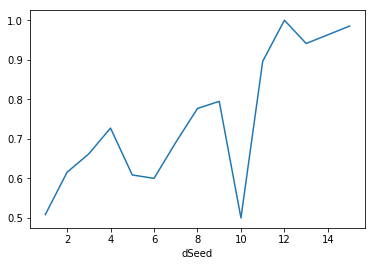

In [10]:
tourney_result['dSeed'] = np.abs(tourney_result['LSeed'] - tourney_result['WSeed'])
tourney_result['P_dSeed_win'] = np.where(tourney_result['LSeed'] > tourney_result['WSeed'],1,0)
win_seed_distribution = tourney_result.groupby(['dSeed'])['P_dSeed_win'].mean()[1:]
win_seed_distribution.plot()
tourney_result.drop(['P_dSeed_win'],axis = 1,inplace = True)

It looks like dSeed is extremely powerful feature for prediction, there is obvious a trend (but somewhere we have small amount of games, therefore most likely we don't have clear linear trend). It will be interesting to built just seed-based model, and i'm going to do it later.

Open detailed results:

In [11]:
season_detailed_result = pd.read_csv('MDataFiles_Stage1/MRegularSeasonDetailedResults.csv')
season_detailed_result.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


Now i'm splitting results from win/lose side to just team side.

In [12]:
def split_team_results(df):
    #taking winners score features
    t1_cols = [x for x in df.columns if 'W' in x and x!='WLoc'] 
    #remove W-prefixes
    new_cols = dict()
    for col in t1_cols:
        new_cols[col] = 'Avg'+ col.replace('W','')
    t1_cols += ['Season']
    df_t1 = df[t1_cols].rename(index=str,columns = new_cols)
    df_t1.rename(columns = {'AvgTeamID' : 'TeamID'},inplace = True)
    #taking losers score features
    t2_cols =   [x for x in df.columns if 'L' in x and x!='WLoc'] 
    #remove L-prefixes
    new_cols = dict()
    for col in t2_cols:
        new_cols[col] = 'Avg' + col.replace('L','')
    t2_cols += ['Season']
    df_t2 = df[t2_cols].rename(index=str,columns = new_cols)
    df_t2.rename(columns = {'AvgTeamID' : 'TeamID'},inplace = True)
    return pd.concat([df_t1,df_t2])#.sort_index()#.reset_index(drop=True)
    
season_teams_result = split_team_results(season_detailed_result)
season_teams_result = season_teams_result.groupby(['Season','TeamID']).mean().reset_index()
season_teams_result.head()

,Season,TeamID,AvgScore,AvgFGM,AvgFGA,AvgFGM3,AvgFGA3,AvgFTM,AvgFTA,AvgOR,AvgDR,AvgAst,AvgTO,AvgStl,AvgBlk,AvgPF
0,2003,1102,57.250000,19.142857,39.785714,7.821429,20.821429,11.142857,17.107143,4.178571,16.821429,13.000000,11.428571,5.964286,1.785714,18.750000
1,2003,1103,78.777778,27.148148,55.851852,5.444444,16.074074,19.037037,25.851852,9.777778,19.925926,15.222222,12.629630,7.259259,2.333333,19.851852
2,2003,1104,69.285714,24.035714,57.178571,6.357143,19.857143,14.857143,20.928571,13.571429,23.928571,12.107143,13.285714,6.607143,3.785714,18.035714
3,2003,1105,71.769231,24.384615,61.615385,7.576923,20.769231,15.423077,21.846154,13.500000,23.115385,14.538462,18.653846,9.307692,2.076923,20.230769
4,2003,1106,63.607143,23.428571,55.285714,6.107143,17.642857,10.642857,16.464286,12.285714,23.857143,11.678571,17.035714,8.357143,3.142857,18.178571


In [13]:
tourney_result = tourney_result.merge(season_teams_result,left_on = ['Season','WTeamID'],
                    right_on = ['Season','TeamID'],how='left',copy = True)
tourney_result = tourney_result.merge(season_teams_result,left_on = ['Season','LTeamID'],
                    right_on = ['Season','TeamID'],how='left',copy = True,suffixes = ('_T1','_T2'))
tourney_result.head()

,Season,WTeamID,WScore,LTeamID,LScore,WSeed,LSeed,dSeed,TeamID_T1,AvgScore_T1,...,AvgFGA3_T2,AvgFTM_T2,AvgFTA_T2,AvgOR_T2,AvgDR_T2,AvgAst_T2,AvgTO_T2,AvgStl_T2,AvgBlk_T2,AvgPF_T2
0,2003,1421,92,1411,84,16,16,0,1421,71.206897,...,18.500000,17.400000,28.066667,13.166667,24.800000,14.200000,15.233333,6.433333,2.233333,18.300000
1,2003,1112,80,1436,51,1,16,15,1112,85.214286,...,15.482759,12.862069,19.551724,12.965517,25.724138,14.206897,14.068966,6.862069,2.965517,15.896552
2,2003,1113,84,1272,71,10,7,3,1113,75.965517,...,20.068966,14.965517,22.896552,14.068966,25.965517,16.620690,13.793103,7.379310,5.068966,18.758621
3,2003,1141,79,1166,73,11,6,5,1141,79.344828,...,20.484848,13.878788,20.030303,10.878788,23.181818,16.818182,13.363636,8.393939,4.454545,17.272727
4,2003,1143,76,1301,74,8,9,1,1143,74.482759,...,22.500000,15.766667,20.466667,9.733333,22.033333,14.666667,14.200000,7.766667,3.066667,18.666667


A little bit more features cleaning:

In [14]:
tourney_result.drop(['WTeamID','LTeamID'],axis = 1,inplace = True)
tourney_result.rename(columns = {'WScore' : 'Score_T1','LScore' : 'Score_T2',
                                'WSeed' : 'Seed_T1', 'LSeed' : 'Seed_T2'},inplace = True)
tourney_result.head()

,Season,Score_T1,Score_T2,Seed_T1,Seed_T2,dSeed,TeamID_T1,AvgScore_T1,AvgFGM_T1,AvgFGA_T1,...,AvgFGA3_T2,AvgFTM_T2,AvgFTA_T2,AvgOR_T2,AvgDR_T2,AvgAst_T2,AvgTO_T2,AvgStl_T2,AvgBlk_T2,AvgPF_T2
0,2003,92,84,16,16,0,1421,71.206897,24.379310,56.793103,...,18.500000,17.400000,28.066667,13.166667,24.800000,14.200000,15.233333,6.433333,2.233333,18.300000
1,2003,80,51,1,16,15,1112,85.214286,30.321429,65.714286,...,15.482759,12.862069,19.551724,12.965517,25.724138,14.206897,14.068966,6.862069,2.965517,15.896552
2,2003,84,71,10,7,3,1113,75.965517,27.206897,56.896552,...,20.068966,14.965517,22.896552,14.068966,25.965517,16.620690,13.793103,7.379310,5.068966,18.758621
3,2003,79,73,11,6,5,1141,79.344828,26.620690,52.689655,...,20.484848,13.878788,20.030303,10.878788,23.181818,16.818182,13.363636,8.393939,4.454545,17.272727
4,2003,76,74,8,9,1,1143,74.482759,27.344828,58.724138,...,22.500000,15.766667,20.466667,9.733333,22.033333,14.666667,14.200000,7.766667,3.066667,18.666667


In [15]:
tourney_result.columns

Index(['Season', 'Score_T1', 'Score_T2', 'Seed_T1', 'Seed_T2', 'dSeed',
       'TeamID_T1', 'AvgScore_T1', 'AvgFGM_T1', 'AvgFGA_T1', 'AvgFGM3_T1',
       'AvgFGA3_T1', 'AvgFTM_T1', 'AvgFTA_T1', 'AvgOR_T1', 'AvgDR_T1',
       'AvgAst_T1', 'AvgTO_T1', 'AvgStl_T1', 'AvgBlk_T1', 'AvgPF_T1',
       'TeamID_T2', 'AvgScore_T2', 'AvgFGM_T2', 'AvgFGA_T2', 'AvgFGM3_T2',
       'AvgFGA3_T2', 'AvgFTM_T2', 'AvgFTA_T2', 'AvgOR_T2', 'AvgDR_T2',
       'AvgAst_T2', 'AvgTO_T2', 'AvgStl_T2', 'AvgBlk_T2', 'AvgPF_T2'],
      dtype='object')

Now i'll duplicate my dataset. It gives me balance in target feature later and increases the the size of train set.For doing this, i wrote a function, which could swap values for given columns (inplace).

In [16]:
def swap_columns(df,A,B):
    #df - dataframe
    #A,B - features names (str)
    #df.loc[:, [B, A]] = df[[A, B]].to_numpy() #for pandas 0.24.0 or higher
    df.loc[:, [B, A]] = np.array(df[[A, B]])
    return df

def duplicate_results(df):
    df_d = df.copy(deep = True)
    t1_cols = [x for x in df_d.columns if '_T1' in x]
    t2_cols = [x for x in df_d.columns if '_T2' in x]
    for A,B in zip(t1_cols,t2_cols):
        swap_columns(df_d,A,B)    
    return pd.concat([df,df_d])

tourney_result = duplicate_results(tourney_result)
tourney_result = tourney_result.reset_index().sort_values(by='index')
tourney_result.drop(['index'],axis = 1,inplace = True)
tourney_result.reset_index(drop = True, inplace = True)
tourney_result.head()

,Season,Score_T1,Score_T2,Seed_T1,Seed_T2,dSeed,TeamID_T1,AvgScore_T1,AvgFGM_T1,AvgFGA_T1,...,AvgFGA3_T2,AvgFTM_T2,AvgFTA_T2,AvgOR_T2,AvgDR_T2,AvgAst_T2,AvgTO_T2,AvgStl_T2,AvgBlk_T2,AvgPF_T2
0,2003,92,84,16,16,0,1421,71.206897,24.379310,56.793103,...,18.500000,17.400000,28.066667,13.166667,24.800000,14.200000,15.233333,6.433333,2.233333,18.300000
1,2003,84,92,16,16,0,1411,72.800000,24.733333,55.266667,...,18.000000,15.965517,20.931034,12.275862,23.172414,13.034483,16.206897,7.068966,3.000000,19.103448
2,2003,51,80,16,1,15,1436,67.793103,24.827586,55.862069,...,20.071429,17.535714,25.000000,15.178571,27.642857,17.642857,14.785714,8.464286,4.214286,17.750000
3,2003,80,51,1,16,15,1112,85.214286,30.321429,65.714286,...,15.482759,12.862069,19.551724,12.965517,25.724138,14.206897,14.068966,6.862069,2.965517,15.896552
4,2003,84,71,10,7,3,1113,75.965517,27.206897,56.896552,...,20.068966,14.965517,22.896552,14.068966,25.965517,16.620690,13.793103,7.379310,5.068966,18.758621


Now i'm able to do final FE. There i've done: team id's to symbols, because there values mean nothing.
I've gone from made throws amount to success percentage, because it works better.
I removed some extra features and created target feature.

In [17]:
tourney_result['dSeed'] =  tourney_result['Seed_T2'] - tourney_result['Seed_T1']
tourney_result['dScore'] = tourney_result['AvgScore_T1'] - tourney_result['AvgScore_T2']
tourney_result['is_T1_win'] = np.where(tourney_result.Score_T1 > tourney_result.Score_T2,1,0)
tourney_result.TeamID_T1 = tourney_result.TeamID_T1.astype(str)
tourney_result.TeamID_T2 = tourney_result.TeamID_T2.astype(str)

tourney_result['1P_T1'] = tourney_result.AvgFTM_T1/tourney_result.AvgFTA_T1
tourney_result['1P_T2'] = tourney_result.AvgFTM_T2/tourney_result.AvgFTA_T2
tourney_result['3P_T1'] = tourney_result.AvgFGM3_T1/tourney_result.AvgFGA3_T1
tourney_result['3P_T2'] = tourney_result.AvgFGM3_T2/tourney_result.AvgFGA3_T2
tourney_result['2P_T1'] = (tourney_result.AvgFGM_T1 - tourney_result.AvgFGM3_T1)/(tourney_result.AvgFGA_T1 - tourney_result.AvgFGA3_T1)
tourney_result['2P_T2'] = (tourney_result.AvgFGM_T2 - tourney_result.AvgFGM3_T2)/(tourney_result.AvgFGA_T2 - tourney_result.AvgFGA3_T2)

tourney_result.drop(['AvgFTM_T1','AvgFGM3_T1','AvgFGM_T1','AvgFTM_T2','AvgFGM3_T2','AvgFGM_T2',
                    'Score_T1','Score_T2'], axis = 1, inplace = True)
tourney_result.head()

,Season,Seed_T1,Seed_T2,dSeed,TeamID_T1,AvgScore_T1,AvgFGA_T1,AvgFGA3_T1,AvgFTA_T1,AvgOR_T1,...,AvgBlk_T2,AvgPF_T2,dScore,is_T1_win,1P_T1,1P_T2,3P_T1,3P_T2,2P_T1,2P_T2
0,2003,16,16,0,1421,71.206897,56.793103,18.000000,20.931034,12.275862,...,2.233333,18.300000,-1.593103,1,0.762768,0.619952,0.360153,0.320721,0.461333,0.511333
1,2003,16,16,0,1411,72.800000,55.266667,18.500000,28.066667,13.166667,...,3.000000,19.103448,1.593103,0,0.619952,0.762768,0.320721,0.360153,0.511333,0.461333
2,2003,16,1,-15,1436,67.793103,55.862069,15.482759,19.551724,12.965517,...,4.214286,17.750000,-17.421182,0,0.657848,0.701429,0.340757,0.350534,0.484202,0.510172
3,2003,1,16,15,1112,85.214286,65.714286,20.071429,25.000000,15.178571,...,2.965517,15.896552,17.421182,1,0.701429,0.657848,0.350534,0.340757,0.510172,0.484202
4,2003,10,7,-3,1113,75.965517,56.896552,12.586207,26.206897,13.689655,...,5.068966,18.758621,1.448276,1,0.669737,0.653614,0.317808,0.348797,0.523735,0.482729


In [18]:
tourney_result['dSeed'] = tourney_result['Seed_T2'] - tourney_result['Seed_T1']

In [19]:
tourney_result.head()

,Season,Seed_T1,Seed_T2,dSeed,TeamID_T1,AvgScore_T1,AvgFGA_T1,AvgFGA3_T1,AvgFTA_T1,AvgOR_T1,...,AvgBlk_T2,AvgPF_T2,dScore,is_T1_win,1P_T1,1P_T2,3P_T1,3P_T2,2P_T1,2P_T2
0,2003,16,16,0,1421,71.206897,56.793103,18.000000,20.931034,12.275862,...,2.233333,18.300000,-1.593103,1,0.762768,0.619952,0.360153,0.320721,0.461333,0.511333
1,2003,16,16,0,1411,72.800000,55.266667,18.500000,28.066667,13.166667,...,3.000000,19.103448,1.593103,0,0.619952,0.762768,0.320721,0.360153,0.511333,0.461333
2,2003,16,1,-15,1436,67.793103,55.862069,15.482759,19.551724,12.965517,...,4.214286,17.750000,-17.421182,0,0.657848,0.701429,0.340757,0.350534,0.484202,0.510172
3,2003,1,16,15,1112,85.214286,65.714286,20.071429,25.000000,15.178571,...,2.965517,15.896552,17.421182,1,0.701429,0.657848,0.350534,0.340757,0.510172,0.484202
4,2003,10,7,-3,1113,75.965517,56.896552,12.586207,26.206897,13.689655,...,5.068966,18.758621,1.448276,1,0.669737,0.653614,0.317808,0.348797,0.523735,0.482729


# Season_Based Model (LGBM)

I've taken params for lgbm from this notebook: https://www.kaggle.com/vbmokin/mm-ncaam-stage-1-lgb-xgb-logreg

Test and valid datasets:

In [189]:
lgb_cols = [x for x in tourney_result.columns if x not in ['TeamID_T1','TeamID_T2','Season']]

In [190]:
df_train = tourney_result[tourney_result.Season < 2015][lgb_cols]
df_valid = tourney_result[tourney_result.Season > 2014][lgb_cols]

target_train = df_train.is_T1_win
target_valid = df_valid.is_T1_win

df_train.drop(['is_T1_win'],axis = 1,inplace = True)
df_valid.drop(['is_T1_win'],axis = 1,inplace = True)

df_valid.head()

,Seed_T1,Seed_T2,dSeed,AvgScore_T1,AvgFGA_T1,AvgFGA3_T1,AvgFTA_T1,AvgOR_T1,AvgDR_T1,AvgAst_T1,...,AvgStl_T2,AvgBlk_T2,AvgPF_T2,dScore,1P_T1,1P_T2,3P_T1,3P_T2,2P_T1,2P_T2
1560,16,16,0,67.151515,55.969697,18.636364,24.303030,12.242424,24.848485,10.606061,...,8.093750,2.781250,22.906250,-2.723485,0.652120,0.694307,0.304065,0.339837,0.459416,0.489262
1561,16,16,0,69.875000,52.687500,19.218750,25.250000,10.406250,21.593750,13.906250,...,6.666667,4.090909,21.545455,2.723485,0.694307,0.652120,0.339837,0.304065,0.489262,0.459416
1562,11,11,0,72.625000,57.812500,19.125000,21.718750,12.406250,25.156250,12.812500,...,7.125000,2.875000,20.531250,-9.218750,0.778417,0.770000,0.338235,0.384503,0.469305,0.503317
1563,11,11,0,81.843750,59.062500,21.375000,25.000000,11.937500,25.843750,16.250000,...,6.593750,3.687500,19.562500,9.218750,0.770000,0.778417,0.384503,0.338235,0.503317,0.469305
1564,11,11,0,68.212121,49.090909,18.333333,23.909091,7.424242,24.121212,13.818182,...,5.967742,2.322581,17.225806,-1.658847,0.681876,0.727941,0.352066,0.391304,0.529064,0.497925


In [191]:
params_lgb = {'objective': 'binary',
              'metric': 'binary_logloss',
              'boosting': 'gbdt',
              'num_leaves': 127,
              'feature_fraction': 0.6,
              'bagging_fraction': 0.6,
              'bagging_freq': 7,
              'learning_rate': 0.001,
              'random_state': 47,
              'n_estimators': 5000,
              'reg_alpha': 0.3899,
              'reg_lambda': 0.648,
}

In [192]:
model = lgb.LGBMClassifier(**params_lgb)

model.fit(df_train, target_train,
                  eval_set=[(df_train, target_train),(df_valid, target_valid)],
                  #num_boost_round=50,
                  early_stopping_rounds=100,
                  verbose=250
                  );

Training until validation scores don't improve for 100 rounds
[250]	training's binary_logloss: 0.632216	valid_1's binary_logloss: 0.654766
[500]	training's binary_logloss: 0.585633	valid_1's binary_logloss: 0.627989
[750]	training's binary_logloss: 0.54857	valid_1's binary_logloss: 0.609976
[1000]	training's binary_logloss: 0.517989	valid_1's binary_logloss: 0.595653
[1250]	training's binary_logloss: 0.492017	valid_1's binary_logloss: 0.586659
[1500]	training's binary_logloss: 0.468867	valid_1's binary_logloss: 0.579314
[1750]	training's binary_logloss: 0.448311	valid_1's binary_logloss: 0.574296
[2000]	training's binary_logloss: 0.429573	valid_1's binary_logloss: 0.570325
[2250]	training's binary_logloss: 0.412051	valid_1's binary_logloss: 0.567415
[2500]	training's binary_logloss: 0.395809	valid_1's binary_logloss: 0.564923
[2750]	training's binary_logloss: 0.380586	valid_1's binary_logloss: 0.563075
[3000]	training's binary_logloss: 0.366329	valid_1's binary_logloss: 0.56202
[3250]	

In [193]:
gbm_probs = model.predict_proba(df_valid)[:,1];

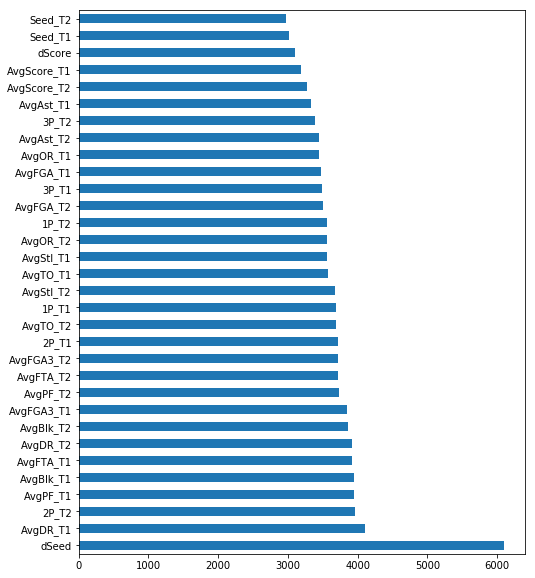

In [194]:
feat_imp = pd.Series(model.feature_importances_, index=df_valid.columns)
feat_imp.nlargest(len(df_valid.columns)).plot(kind='barh', figsize=(8,10));

# Logistic Regression Model

It has taken from: https://www.kaggle.com/omniactio/basic-logistic-regression-with-cross-validation
There i saved for my prediction only low correlated features (pearson correlation < 0.4), so i had to drop features like dSeed.

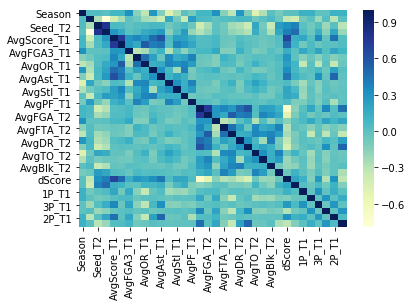

In [208]:
sns.heatmap(tourney_result.corr(),cmap="YlGnBu",annot=False);

In [196]:
log_reg_cols = [x for x in tourney_result.columns if x not in ['TeamID_T1','TeamID_T2','Season','is_T1_win','dSeed','dScore']]
X = tourney_result[tourney_result.Season < 2014][log_reg_cols]
y = tourney_result[tourney_result.Season < 2014]['is_T1_win']

logit_model=sm.Logit(y,X)
log_reg=logit_model.fit()
print(log_reg.summary2())       

Optimization terminated successfully.
         Current function value: 0.529738
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.236     
Dependent Variable: is_T1_win        AIC:              1570.8127 
Date:               2020-03-08 14:33 BIC:              1728.6916 
No. Observations:   1426             Log-Likelihood:   -755.41   
Df Model:           29               LL-Null:          -988.43   
Df Residuals:       1396             LLR p-value:      2.6437e-80
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                 Coef.   Std.Err.    z    P>|z|   [0.025   0.975]
-----------------------------------------------------------------
Seed_T1          -0.1486   0.0195 -7.6183 0.0000  -0.1868 -0.1104
Seed_T2           0.1486   0.0195  7.6183 0.0000   0.1104  0.1868


In [197]:
log_reg_probs = log_reg.predict(test_df[log_reg_cols])

# Test Data Engineering

In [198]:
test_df = pd.read_csv('MSampleSubmissionStage1_2020.csv')

In [199]:
test_df['Season'] = test_df['ID'].map(lambda x: int(x[:4]))
test_df['TeamID_T1'] = test_df['ID'].map(lambda x: int(x[5:9]))
test_df['TeamID_T2'] = test_df['ID'].map(lambda x: int(x[10:14]))
test_df.head()

,ID,Pred,Season,TeamID_T1,TeamID_T2
0,2015_1107_1112,0.5,2015,1107,1112
1,2015_1107_1116,0.5,2015,1107,1116
2,2015_1107_1124,0.5,2015,1107,1124
3,2015_1107_1125,0.5,2015,1107,1125
4,2015_1107_1129,0.5,2015,1107,1129


Add seeds info:

In [200]:
tourney_seed = pd.read_csv('MDataFiles_Stage1/MNCAATourneySeeds.csv')

In [201]:
tourney_seed.columns = ['Season','Seed_T1','TeamID_T1']
test_df = test_df.merge(tourney_seed, on = ['Season','TeamID_T1'],how='left')
tourney_seed.columns = ['Season','Seed_T2','TeamID_T2']
test_df = test_df.merge(tourney_seed, on = ['Season','TeamID_T2'],how='left')
test_df['Seed_T1'] = test_df['Seed_T1'].apply(lambda x: int(x[1:3]))
test_df['Seed_T2'] = test_df['Seed_T2'].apply(lambda x: int(x[1:3]))
test_df.head()

,ID,Pred,Season,TeamID_T1,TeamID_T2,Seed_T1,Seed_T2
0,2015_1107_1112,0.5,2015,1107,1112,14,2
1,2015_1107_1116,0.5,2015,1107,1116,14,5
2,2015_1107_1124,0.5,2015,1107,1124,14,3
3,2015_1107_1125,0.5,2015,1107,1125,14,15
4,2015_1107_1129,0.5,2015,1107,1129,14,11


Add info from season results from FE for model:

In [202]:
test_df = test_df.merge(season_teams_result,left_on = ['Season','TeamID_T1'],
                    right_on = ['Season','TeamID'],how='left',copy = True)
test_df = test_df.merge(season_teams_result,left_on = ['Season','TeamID_T2'],
                    right_on = ['Season','TeamID'],how='left',copy = True,suffixes = ('_T1','_T2'))

Add a bit more FE finally:

In [203]:
test_df['dSeed'] = test_df['Seed_T2'] - test_df['Seed_T1']
test_df['dScore'] = test_df['AvgScore_T1'] - test_df['AvgScore_T2']
#test_df.TeamID_T1 = test_df.TeamID_T1.astype(str)
#test_df.TeamID_T2 = test_df.TeamID_T2.astype(str)

test_df['1P_T1'] = test_df.AvgFTM_T1/test_df.AvgFTA_T1
test_df['1P_T2'] = test_df.AvgFTM_T2/test_df.AvgFTA_T2
test_df['3P_T1'] = test_df.AvgFGM3_T1/test_df.AvgFGA3_T1
test_df['3P_T2'] = test_df.AvgFGM3_T2/test_df.AvgFGA3_T2
test_df['2P_T1'] = (test_df.AvgFGM_T1 - test_df.AvgFGM3_T1)/(test_df.AvgFGA_T1 - test_df.AvgFGA3_T1)
test_df['2P_T2'] = (test_df.AvgFGM_T2 - test_df.AvgFGM3_T2)/(test_df.AvgFGA_T2 - test_df.AvgFGA3_T2)

test_df.drop(['AvgFTM_T1','AvgFGM3_T1','AvgFGM_T1','AvgFTM_T2','AvgFGM3_T2','AvgFGM_T2'], axis = 1, inplace = True)
test_df.head()

,ID,Pred,Season,TeamID_T1,TeamID_T2,Seed_T1,Seed_T2,TeamID_T1,AvgScore_T1,AvgFGA_T1,...,AvgBlk_T2,AvgPF_T2,dSeed,dScore,1P_T1,1P_T2,3P_T1,3P_T2,2P_T1,2P_T2
0,2015_1107_1112,0.5,2015,1107,1112,14,2,1107,65.5,50.15625,...,3.588235,17.911765,-12,-10.941176,0.760938,0.699085,0.360146,0.359833,0.481096,0.534495
1,2015_1107_1116,0.5,2015,1107,1116,14,5,1107,65.5,50.15625,...,4.764706,18.970588,-9,-12.529412,0.760938,0.724227,0.360146,0.350309,0.481096,0.491289
2,2015_1107_1124,0.5,2015,1107,1124,14,3,1107,65.5,50.15625,...,3.843750,16.718750,-11,-3.625000,0.760938,0.666667,0.360146,0.382253,0.481096,0.459712
3,2015_1107_1125,0.5,2015,1107,1125,14,15,1107,65.5,50.15625,...,1.967742,16.451613,1,-8.274194,0.760938,0.690090,0.360146,0.378713,0.481096,0.562144
4,2015_1107_1129,0.5,2015,1107,1129,14,11,1107,65.5,50.15625,...,2.322581,17.225806,-3,-4.370968,0.760938,0.727941,0.360146,0.391304,0.481096,0.497925


Model's calculation:

In [204]:
lgb_cols.remove('is_T1_win')
ids = test_df.ID
test_df = test_df[lgb_cols]
gbm_probs = model.predict_proba(test_df)[:,1]

Write answer:

In [205]:
my_pred = gbm_probs*0.0 + log_reg_probs*1.0

In [206]:
submission_df = pd.DataFrame({'ID': ids, 'Pred': my_pred})
submission_df.head()

,ID,Pred
0,2015_1107_1112,0.118682
1,2015_1107_1116,0.207189
2,2015_1107_1124,0.145780
3,2015_1107_1125,0.643517
4,2015_1107_1129,0.364683


In [207]:
submission_df.to_csv('submission.csv', index=False)